In [1]:
# Initial imports
import os
import csv
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import warnings
from pathlib import Path
import datetime as dt

#Subsequent imports
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import hvplot.pandas

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression as lr
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Enable the Matplotlib property to allow diagrams to display in Jupyter Notebook
%matplotlib inline

In [2]:
# List the ticker symbols for the stocks of interest
lst_Stocks = ['BMO.TO', 'BNS.TO', 'CM.TO', 'NA.TO','RY.TO', 'TD.TO', 'ZEB.TO','ZWB.TO', 'XGB.TO', 'CL' ]
ticker = ['NA.TO']

# Determine the Date range for the desired data
start_date = '2014-01-01'
end_date = '2022-12-31'
df = yf.download(ticker, start= start_date, end= end_date)
df = df.sort_index()


[*********************100%***********************]  1 of 1 completed


In [3]:
# Feature Engineering

# Mid Rang Variables
df['Mid_hl'] = (df['High'] + df['Low']) /2 
df['Mid_oc'] = (df['Open'] + df['Close']) /2 
df['Mid_hloc'] = (df['High'] + df['Low'] + df['Open'] + df['Close']) /4 

# Close in Range ==> Close at Low = 0, Close at High = 1
df['Close_in_range'] = 1 - ((df['High'] - df['Close']) / (df['High'] - df['Low']) )

# Daily/Weekly Returns - Average of Open and Close
df['Returns_1Day_Moc'] = df['Mid_oc'].pct_change()
df['Returns_5Day_Moc'] = df['Mid_oc'].pct_change(5)
df['Returns_30Day_Moc'] = df['Mid_oc'].pct_change(30)

# Daily/Weekly Returns - Average of High Low Open Close
df['Returns_1Day_Mhloc'] = df['Mid_hloc'].pct_change()
df['Returns_5Day_Mhloc'] = df['Mid_hloc'].pct_change(5)
df['Returns_30Day_Mhloc'] = df['Mid_hloc'].pct_change(30)

# Daily/Weekly Standard Deviation - Average of Open and Close
df['Std_Dev_10Day_Moc'] = df['Mid_oc'].rolling(10).std()
df['Std_Dev_30Day_Moc'] = df['Mid_oc'].rolling(30).std()

# Daily/Weekly Standard Deviation - Average of Open and Close
df['Std_Dev_10Day_Mhloc'] = df['Mid_hloc'].rolling(10).std()
df['Std_Dev_30Day_Mhloc'] = df['Mid_hloc'].rolling(30).std()

# Simple Moving Average - 8 Day vs 20 Day
df['SMA_Returns_8Day_Mhloc'] = df['Returns_1Day_Moc'].rolling(8).std()
df['SMA_Returns_20Day_Mhloc'] = df['Returns_1Day_Moc'].rolling(20).std()
df['SMA_Delta_8_20Day_Mhloc'] = df['SMA_Returns_8Day_Mhloc'] - df['SMA_Returns_20Day_Mhloc']
df['SMA_Signal_8_20Day_Mhloc'] = np.where(df['SMA_Returns_8Day_Mhloc'] < 1, 0, 1) 

# Display
display(df.columns)
display(df.head(10))
display(df.tail(10))

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Mid_hl',
       'Mid_oc', 'Mid_hloc', 'Close_in_range', 'Returns_1Day_Moc',
       'Returns_5Day_Moc', 'Returns_30Day_Moc', 'Returns_1Day_Mhloc',
       'Returns_5Day_Mhloc', 'Returns_30Day_Mhloc', 'Std_Dev_10Day_Moc',
       'Std_Dev_30Day_Moc', 'Std_Dev_10Day_Mhloc', 'Std_Dev_30Day_Mhloc',
       'SMA_Returns_8Day_Mhloc', 'SMA_Returns_20Day_Mhloc',
       'SMA_Delta_8_20Day_Mhloc', 'SMA_Signal_8_20Day_Mhloc'],
      dtype='object')

Open       High        Low      Close  \
Date                                                                    
2014-01-02 00:00:00-05:00  44.150002  44.195000  43.759998  44.154999   
2014-01-03 00:00:00-05:00  44.174999  44.195000  43.799999  44.125000   
2014-01-06 00:00:00-05:00  44.084999  44.084999  43.535000  43.630001   
2014-01-07 00:00:00-05:00  43.740002  43.849998  43.505001  43.514999   
2014-01-08 00:00:00-05:00  43.584999  43.674999  43.325001  43.540001   
2014-01-09 00:00:00-05:00  43.685001  44.005001  43.474998  43.965000   
2014-01-10 00:00:00-05:00  44.090000  44.099998  43.810001  44.049999   
2014-01-13 00:00:00-05:00  44.009998  44.095001  43.875000  44.049999   
2014-01-14 00:00:00-05:00  44.139999  44.165001  43.650002  43.665001   
2014-01-15 00:00:00-05:00  43.750000  44.044998  43.634998  44.005001   

                           Adj Close   Volume     Mid_hl     Mid_oc  \
Date                                                                  
2014-01-02 00:00:00-05:00  30.764410  1300800  43.977499  44.152500   
2014-01-03 00:00:00-05:00  30.743500   713800  43.997499  44.150000   
2014-01-06 00:00:00-05:00  30.398621  1329400  43.809999  43.857500   
2014-01-07 00:00:00-05:00  30.318489   916600  43.677500  43.627501   
2014-01-08 00:00:00-05:00  30.335909   889000  43.500000  43.562500   
2014-01-09 00:00:00-05:00  30.632025  1218400  43.740000  43.825001   
2014-01-10 00:00:00-05:00  30.691246  1338400  43.955000  44.070000   
2014-01-13 00:00:00-05:00  30.691246  1384400  43.985001  44.029999   
2014-01-14 00:00:00-05:00  30.423010  1241600  43.907501  43.902500   
2014-01-15 00:00:00-05:00  30.659893   877600  43.839998  43.877501   

                            Mid_hloc  Close_in_range  ...  Returns_5Day_Mhloc  \
Date                                                  ...                       
2014-01-02 00:00:00-05:00  44.065000        0.908044  ...                 NaN   
2014-01-03 00:00:00-05:00  44.073750        0.822786  ...                 NaN   
2014-01-06 00:00:00-05:00  43.833750        0.172730  ...                 NaN   
2014-01-07 00:00:00-05:00  43.652500        0.028981  ...                 NaN   
2014-01-08 00:00:00-05:00  43.531250        0.614289  ...                 NaN   
2014-01-09 00:00:00-05:00  43.782500        0.924527  ...           -0.006411   
2014-01-10 00:00:00-05:00  44.012500        0.827587  ...           -0.001390   
2014-01-13 00:00:00-05:00  44.007500        0.795447  ...            0.003964   
2014-01-14 00:00:00-05:00  43.905001        0.029125  ...            0.005784   
2014-01-15 00:00:00-05:00  43.858749        0.902446  ...            0.007523   

                           Returns_30Day_Mhloc  Std_Dev_10Day_Moc  \
Date                                                                
2014-01-02 00:00:00-05:00                  NaN                NaN   
2014-01-03 00:00:00-05:00                  NaN                NaN   
2014-01-06 00:00:00-05:00                  NaN                NaN   
2014-01-07 00:00:00-05:00                  NaN                NaN   
2014-01-08 00:00:00-05:00                  NaN                NaN   
2014-01-09 00:00:00-05:00                  NaN                NaN   
2014-01-10 00:00:00-05:00                  NaN                NaN   
2014-01-13 00:00:00-05:00                  NaN                NaN   
2014-01-14 00:00:00-05:00                  NaN                NaN   
2014-01-15 00:00:00-05:00                  NaN           0.202171   

                           Std_Dev_30Day_Moc  Std_Dev_10Day_Mhloc  \
Date                                                                
2014-01-02 00:00:00-05:00                NaN                  NaN   
2014-01-03 00:00:00-05:00                NaN                  NaN   
2014-01-06 00:00:00-05:00                NaN                  NaN   
2014-01-07 00:00:00-05:00                NaN                  NaN   
2014-01-08 00:00:00-05:00                NaN                  NaN   
2014-01-09 00:00:

Open       High        Low      Close  \
Date                                                                    
2022-12-15 00:00:00-05:00  92.730003  93.160004  92.360001  93.010002   
2022-12-16 00:00:00-05:00  92.500000  92.919998  92.169998  92.400002   
2022-12-19 00:00:00-05:00  92.419998  93.220001  91.029999  91.230003   
2022-12-20 00:00:00-05:00  91.639999  92.699997  91.139999  92.050003   
2022-12-21 00:00:00-05:00  92.730003  93.779999  92.500000  92.949997   
2022-12-22 00:00:00-05:00  91.830002  92.120003  90.760002  91.400002   
2022-12-23 00:00:00-05:00  91.500000  92.260002  90.910004  92.169998   
2022-12-28 00:00:00-05:00  92.000000  92.300003  90.959999  91.019997   
2022-12-29 00:00:00-05:00  91.250000  91.919998  91.199997  91.699997   
2022-12-30 00:00:00-05:00  91.290001  91.910004  91.099998  91.230003   

                           Adj Close   Volume     Mid_hl     Mid_oc  \
Date                                                                  
2022-12-15 00:00:00-05:00  92.039375  1178600  92.760002  92.870003   
2022-12-16 00:00:00-05:00  91.435745  3044100  92.544998  92.450001   
2022-12-19 00:00:00-05:00  90.277954  6197400  92.125000  91.825001   
2022-12-20 00:00:00-05:00  91.089394  2644000  91.919998  91.845001   
2022-12-21 00:00:00-05:00  91.979996  5391300  93.139999  92.840000   
2022-12-22 00:00:00-05:00  91.400002  4854000  91.440002  91.615002   
2022-12-23 00:00:00-05:00  92.169998  1953500  91.585003  91.834999   
2022-12-28 00:00:00-05:00  91.019997   887800  91.630001  91.509998   
2022-12-29 00:00:00-05:00  91.699997   399300  91.559998  91.474998   
2022-12-30 00:00:00-05:00  91.230003   412700  91.505001  91.260002   

                            Mid_hloc  Close_in_range  ...  Returns_5Day_Mhloc  \
Date                                                  ...                       
2022-12-15 00:00:00-05:00  92.815002        0.812499  ...           -0.012685   
2022-12-16 00:00:00-05:00  92.497499        0.306671  ...           -0.019297   
2022-12-19 00:00:00-05:00  91.975000        0.091326  ...           -0.027286   
2022-12-20 00:00:00-05:00  91.882500        0.583337  ...           -0.029675   
2022-12-21 00:00:00-05:00  92.990000        0.351560  ...           -0.008873   
2022-12-22 00:00:00-05:00  91.527502        0.470588  ...           -0.013872   
2022-12-23 00:00:00-05:00  91.710001        0.933330  ...           -0.008514   
2022-12-28 00:00:00-05:00  91.570000        0.044774  ...           -0.004403   
2022-12-29 00:00:00-05:00  91.517498        0.694443  ...           -0.003972   
2022-12-30 00:00:00-05:00  91.382502        0.160499  ...           -0.017287   

                           Returns_30Day_Mhloc  Std_Dev_10Day_Moc  \
Date                                                                
2022-12-15 00:00:00-05:00             0.012187           0.729353   
2022-12-16 00:00:00-05:00            -0.005964           0.844051   
2022-12-19 00:00:00-05:00            -0.025843           1.027740   
2022-12-20 00:00:00-05:00            -0.033401           1.147725   
2022-12-21 00:00:00-05:00            -0.018808           1.132392   
2022-12-22 00:00:00-05:00            -0.049879           1.231459   
2022-12-23 00:00:00-05:00            -0.051848           1.210399   
2022-12-28 00:00:00-05:00            -0.050572           1.063136   
2022-12-29 00:00:00-05:00            -0.053838           0.759578   
2022-12-30 00:00:00-05:00            -0.050941           0.571146   

                           Std_Dev_30Day_Moc  Std_Dev_10Day_Mhloc  \
Date                                                                
2022-12-15 00:00:00-05:00           1.726470             0.725354   
2022-12-16 00:00:00-05:00           1.769546             0.798617   
2022-12-19 00:00:00-05:00           1.900823             0.953741   
2022-12-20 00:00:00-05:00           2.028377             1.094531   
2022-12-21 00:00:00-05:00           2.089159             1.055799   
2022-12-22 00:00:

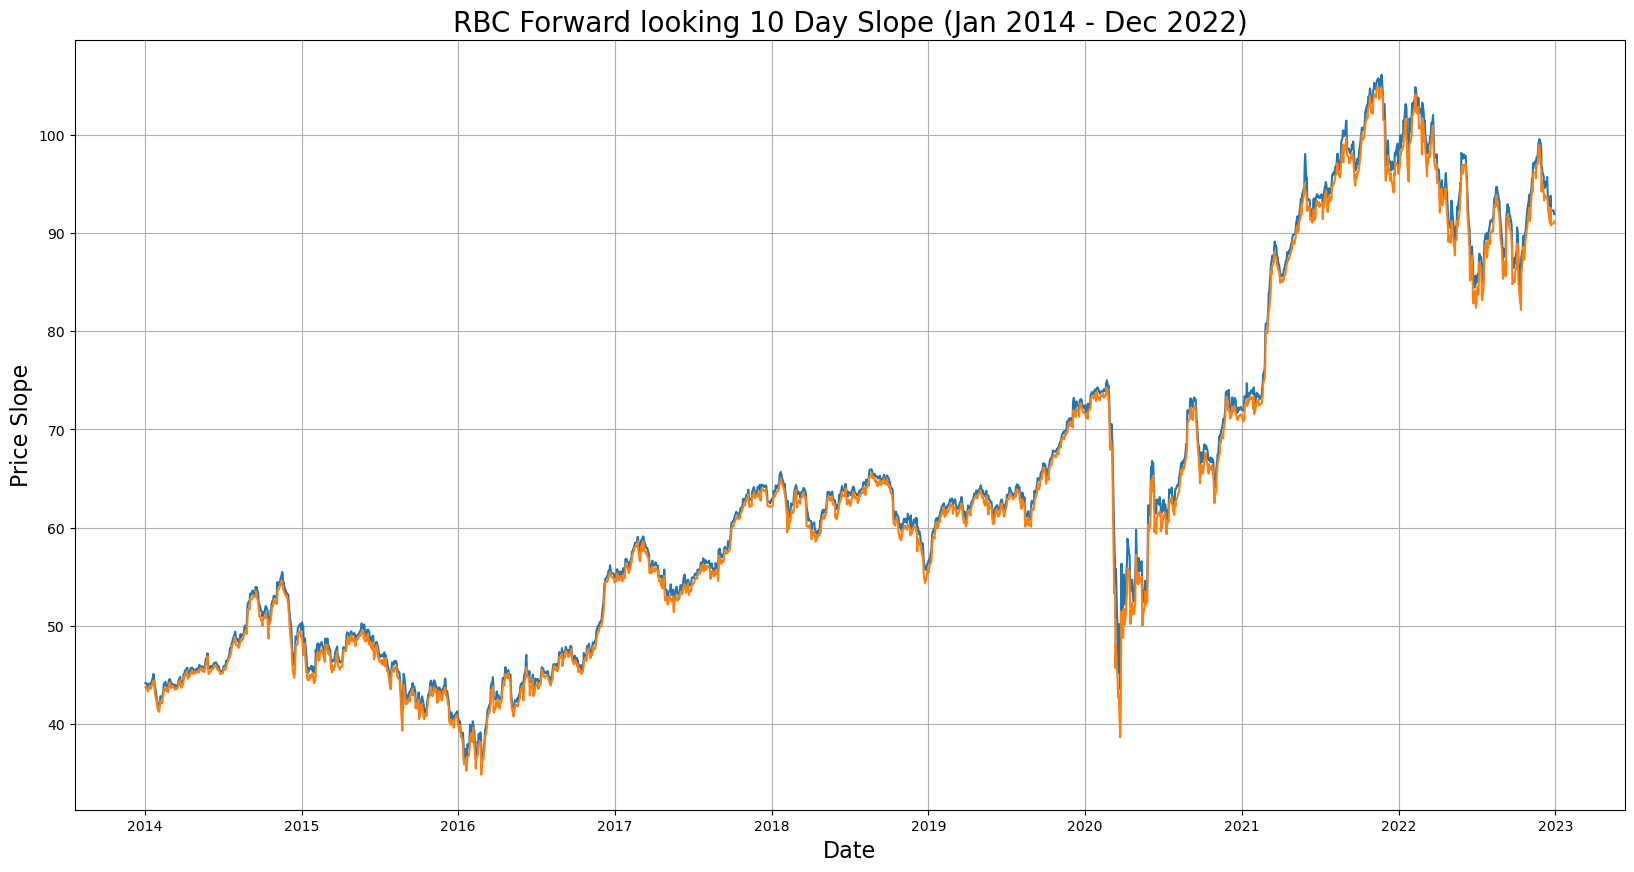

In [4]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

#plt.plot(df_all_stocks_model[['RY.TO']])
plt.plot(df[['High']], label='High')
plt.plot(df[['Low']], label='Low')
#plt.title("Royal Bank of Canada (RY) Daily Close (Jan 2014 - Sep 2022)", fontsize = 20)
plt.title("RBC Forward looking 10 Day Slope (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price Slope", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
#plt.legend('High', 'Low')
#plt.legend(df_RYx.columns)
plt.grid()

plt.show()


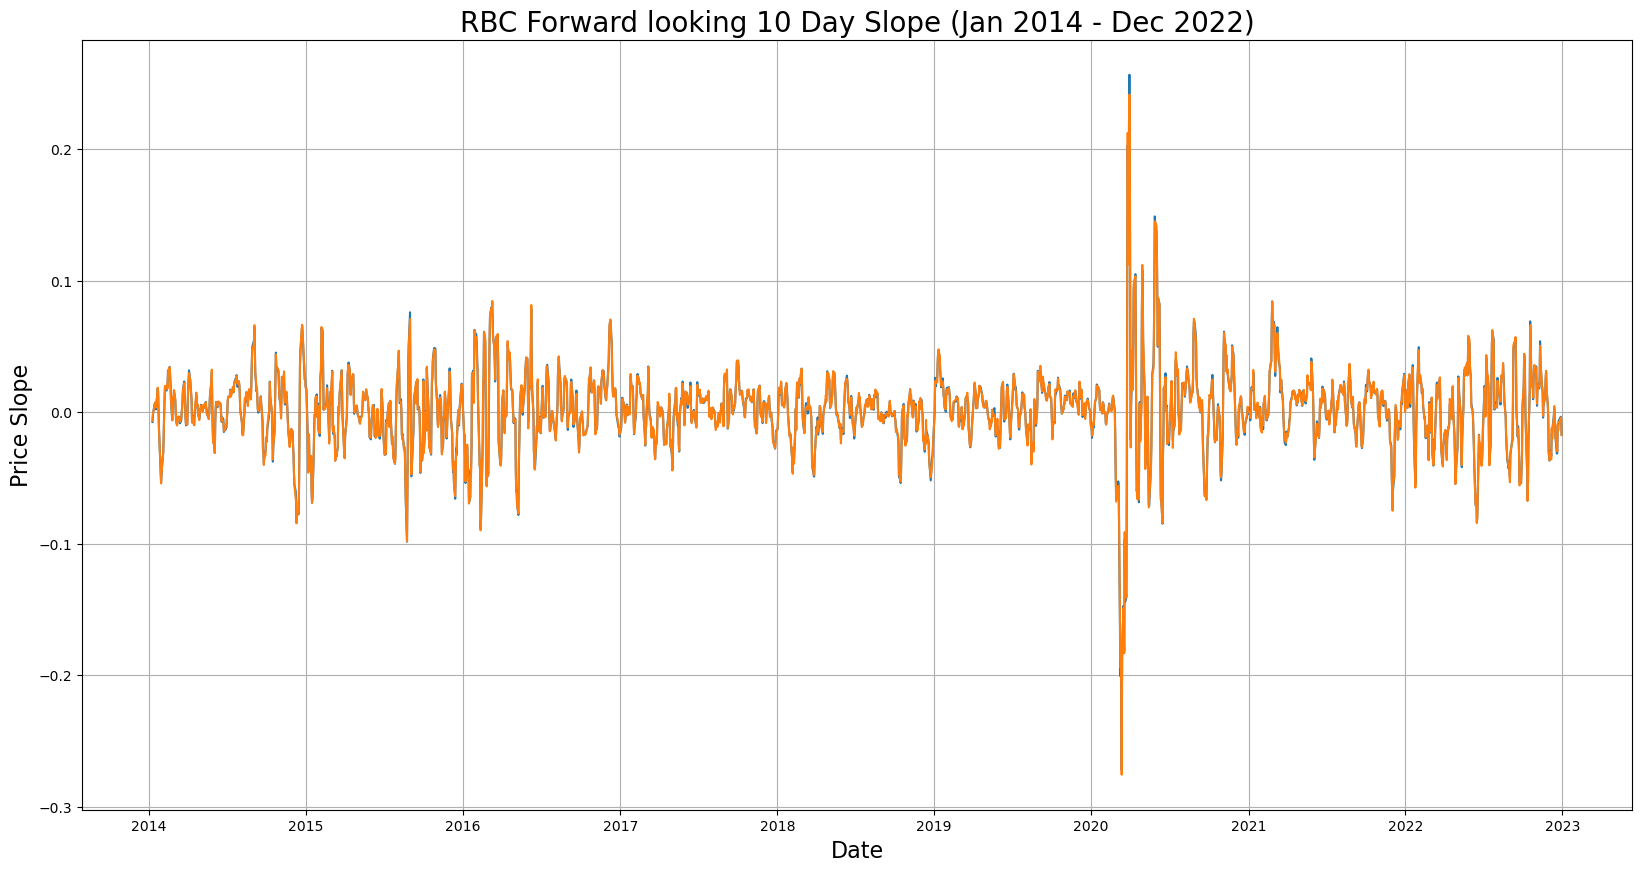

In [5]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

#plt.plot(df_all_stocks_model[['RY.TO']])
plt.plot(df[['Returns_5Day_Moc']], label='Open-Close')
plt.plot(df[['Returns_5Day_Mhloc']], label='High-Low-Open-Close')
#plt.title("Royal Bank of Canada (RY) Daily Close (Jan 2014 - Sep 2022)", fontsize = 20)
plt.title("RBC Forward looking 10 Day Slope (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price Slope", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
#plt.legend('High', 'Low')
#plt.legend(df_RYx.columns)
plt.grid()

plt.show()


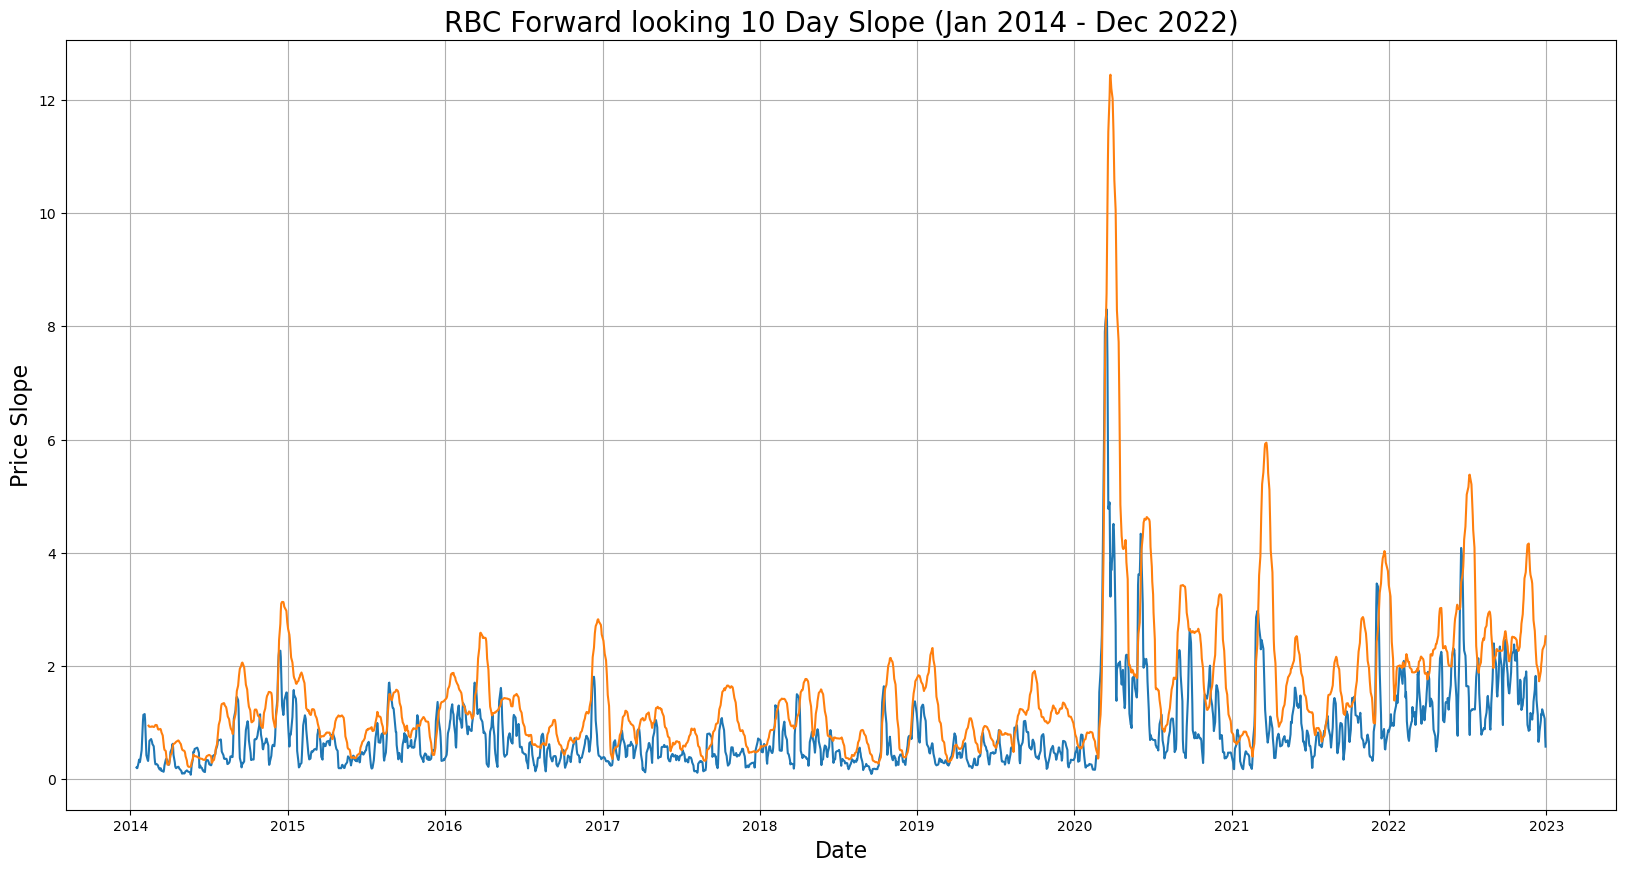

In [6]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

#plt.plot(df_all_stocks_model[['RY.TO']])
plt.plot(df[['Std_Dev_10Day_Moc']], label='High')
plt.plot(df[['Std_Dev_30Day_Moc']], label='Low')
#plt.title("Royal Bank of Canada (RY) Daily Close (Jan 2014 - Sep 2022)", fontsize = 20)
plt.title("RBC Forward looking 10 Day Slope (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price Slope", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
#plt.legend('High', 'Low')
#plt.legend(df_RYx.columns)
plt.grid()

plt.show()


In [7]:
# Prepare df for trend determination
df = df.sort_index()
df = df.reset_index()
df

Date       Open       High        Low      Close  \
0    2014-01-02 00:00:00-05:00  44.150002  44.195000  43.759998  44.154999   
1    2014-01-03 00:00:00-05:00  44.174999  44.195000  43.799999  44.125000   
2    2014-01-06 00:00:00-05:00  44.084999  44.084999  43.535000  43.630001   
3    2014-01-07 00:00:00-05:00  43.740002  43.849998  43.505001  43.514999   
4    2014-01-08 00:00:00-05:00  43.584999  43.674999  43.325001  43.540001   
...                        ...        ...        ...        ...        ...   
2253 2022-12-22 00:00:00-05:00  91.830002  92.120003  90.760002  91.400002   
2254 2022-12-23 00:00:00-05:00  91.500000  92.260002  90.910004  92.169998   
2255 2022-12-28 00:00:00-05:00  92.000000  92.300003  90.959999  91.019997   
2256 2022-12-29 00:00:00-05:00  91.250000  91.919998  91.199997  91.699997   
2257 2022-12-30 00:00:00-05:00  91.290001  91.910004  91.099998  91.230003   

      Adj Close   Volume     Mid_hl     Mid_oc   Mid_hloc  ...  \
0     30.764410  1300800  43.977499  44.152500  44.065000  ...   
1     30.743500   713800  43.997499  44.150000  44.073750  ...   
2     30.398621  1329400  43.809999  43.857500  43.833750  ...   
3     30.318489   916600  43.677500  43.627501  43.652500  ...   
4     30.335909   889000  43.500000  43.562500  43.531250  ...   
...         ...      ...        ...        ...        ...  ...   
2253  91.400002  4854000  91.440002  91.615002  91.527502  ...   
2254  92.169998  1953500  91.585003  91.834999  91.710001  ...   
2255  91.019997   887800  91.630001  91.509998  91.570000  ...   
2256  91.699997   399300  91.559998  91.474998  91.517498  ...   
2257  91.230003   412700  91.505001  91.260002  91.382502  ...   

      Returns_5Day_Mhloc  Returns_30Day_Mhloc  Std_Dev_10Day_Moc  \
0                    NaN                  NaN                NaN   
1                    NaN                  NaN                NaN   
2                    NaN                  NaN                NaN   
3                    NaN                  NaN                NaN   
4                    NaN                  NaN                NaN   
...                  ...                  ...                ...   
2253           -0.013872            -0.049879           1.231459   
2254           -0.008514            -0.051848           1.210399   
2255           -0.004403            -0.050572           1.063136   
2256           -0.003972            -0.053838           0.759578   
2257           -0.017287            -0.050941           0.571146   

      Std_Dev_30Day_Moc  Std_Dev_10Day_Mhloc  Std_Dev_30Day_Mhloc  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2                   NaN                  NaN                  NaN   
3                   NaN                  NaN                  NaN   
4                   NaN                  NaN                  NaN   
...                 ...                  ...                  ...   
2253           2.205606             1.170652             2.210110   
2254           2.285294             1.161553             2.298344   
2255           2.376199             1.052183             2.384122   
2256           2.445994             0.776057             2.451958   
2257           2.521851             0.578396             2.522085   

      SMA_Returns_8Day_Mhloc  SMA_Returns_20Day_Mhloc  \
0                        NaN                      NaN   
1                        NaN                      NaN   
2                        NaN                      NaN   
3                        NaN                      NaN   
4                        NaN                      NaN   
...                      ...                      ...   
2253                0.007727                 0.007115   
2254                0.007980                 0.007184   
2255                0.007540                 0.006900   
2256                0.007053                 0.006914   
2257                0.0

In [8]:
# Calculate the 10-day forward looking slope of daily price benchmarks 
# Slope = coefecient from sklearn regression model
# Price Benchmarks = high, low, open, close

# Initialize X variable 1-10 
X = np.array([[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]])

# Initialize results dataframe
df_target_y = pd.DataFrame(columns = ['index', 'high_slope','high_intercept', 'mid_hl_slope', 'mid_hl_intercept', 'mid_oc_slope', 'mid_oc_intercept', 'low_slope', 'low_intercept', 'trend_10day'])

# Calculate from 1st to last less 10 days
for i in range(len(df) - 10):
    
    # Initialize y variables
    trend = 10
    y_High = np.array([])
    y_Mid_hl = np.array([])
    y_Mid_oc = np.array([])
    y_Low = np.array([])
    count = 0
    
    # Calculate y variables and add them to the array
    for j in range (i , i + 10):
        y_High = np.insert(y_High, len(y_High), df['High'].iloc[[j]])
        y_Mid_hl = np.insert(y_Mid_hl, len(y_Mid_hl), (df['High'].iloc[[j]] + df['Low'].iloc[[j]])/2)
        y_Mid_oc = np.insert(y_Mid_oc, len(y_Mid_oc), (df['Open'].iloc[[j]] + df['Close'].iloc[[j]])/2)
        y_Low = np.insert(y_Low, len(y_Low), df['Low'].iloc[[j]])
        count += 1
    
    # Reshape the y array for the regression model   
    y_High = y_High.reshape(-1,1)
    y_Mid_hl = y_Mid_hl.reshape(-1,1)
    y_Mid_oc = y_Mid_oc.reshape(-1,1)
    y_Low = y_Low.reshape(-1,1)
    
    # Regression models
    reg_High = LinearRegression().fit(X, y_High)
    reg_Mid_hl = LinearRegression().fit(X, y_Mid_hl)
    reg_Mid_oc = LinearRegression().fit(X, y_Mid_oc)
    reg_Low = LinearRegression().fit(X, y_Low)
    
    # Determine trend 
    # 0 - Down = 3 negative coefecients or 2 negative and the sum of all 4 is negative
    # 1 - Up   = 3 positive coefecients or 2 positive and the sum of all 4 is positive
    if (reg_High.coef_ > 0 and reg_Mid_hl.coef_ > 0 and reg_Mid_oc.coef_ > 0):
        trend = 1
    elif (reg_High.coef_ > 0 and reg_Mid_oc.coef_ > 0 and reg_Low.coef_ > 0): 
        trend = 1
    elif (reg_Mid_hl.coef_ > 0 and reg_Mid_oc.coef_ > 0 and reg_Low.coef_ > 0):
        trend = 1
    elif (reg_High.coef_ < 0 and reg_Mid_hl.coef_ < 0 and reg_Mid_oc.coef_ < 0):
        trend = 0
    elif (reg_High.coef_ < 0 and reg_Mid_oc.coef_ < 0 and reg_Low.coef_ < 0): 
        trend = 0
    elif (reg_Mid_hl.coef_ < 0 and reg_Mid_oc.coef_ < 0 and reg_Low.coef_ < 0):
        trend = 0
    elif (reg_High.coef_  + reg_Mid_hl.coef_ + reg_Mid_oc.coef_ + reg_Low.coef_ > 0):
        trend = 1    
    else: 
        trend =0
    
    # Populate result dataframe
    df_temp = pd.DataFrame({"index":i,  "high_slope": reg_High.coef_[0],     "high_intercept": reg_High.intercept_[0], 
                                        "mid_hl_slope": reg_Mid_hl.coef_[0], "mid_hl_intercept": reg_Mid_hl.intercept_[0],
                                        "mid_oc_slope": reg_Mid_oc.coef_[0], "mid_oc_intercept": reg_Mid_oc.intercept_[0], 
                                        "low_slope": reg_Low.coef_[0],       "low_intercept": reg_Low.intercept_[0],
                                        "trend_10day": trend})
    
    df_target_y = pd.concat([df_target_y,df_temp], axis = "rows")
    
    #print(f" row {i} xxx High: {reg_High.coef_} xxx Mid HiLo: {reg_Mid_hl.coef_} xxx Mid OpCl: {reg_Mid_oc.coef_} xxx Low: {reg_Low.coef_} xxx {trend}")
    #print('========================')

# Display result Dataframe
df_target_y = df_target_y.set_index(['index'])
display(df_target_y)

C:\Users\jersk\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


high_slope  high_intercept  mid_hl_slope  mid_hl_intercept  \
index                                                               
0       -0.002606       44.055333      0.000485         43.836333   
1        0.010606       43.972666      0.012909         43.759999   
2        0.041939       43.821333      0.042909         43.613000   
3        0.086576       43.650332      0.080727         43.483000   
4        0.121788       43.582666      0.110076         43.430833   
...           ...             ...           ...               ...   
2243    -0.248667       95.396667     -0.262424         94.807334   
2244    -0.316727       95.526000     -0.319970         94.860334   
2245    -0.318788       95.263334     -0.322333         94.601333   
2246    -0.293455       94.866001     -0.289273         94.151999   
2247    -0.203576       93.994668     -0.207273         93.396000   

       mid_oc_slope  mid_oc_intercept  low_slope  low_intercept trend_10day  
index                                                                        
0         -0.010636         43.964000   0.003576      43.617333           0  
1          0.013439         43.820833   0.015212      43.547333           1  
2          0.045333         43.647167   0.043879      43.404667           1  
3          0.080833         43.525666   0.074879      43.315667           1  
4          0.096970         43.542666   0.098364      43.279000           1  
...             ...               ...        ...            ...         ...  
2243      -0.303576         95.016667  -0.276182      94.218001           0  
2244      -0.358515         95.086333  -0.323212      94.194667           0  
2245      -0.347273         94.775002  -0.325879      93.939332           0  
2246      -0.291849         94.140669  -0.285090      93.437997           0  
2247      -0.200394         93.307669  -0.210969      92.797332           0  

[2248 rows x 9 columns]

In [9]:
df = pd.concat([df, df_target_y], axis= 1)
display(df.head(11))
display(df.tail(11))

Date       Open       High        Low      Close  \
0  2014-01-02 00:00:00-05:00  44.150002  44.195000  43.759998  44.154999   
1  2014-01-03 00:00:00-05:00  44.174999  44.195000  43.799999  44.125000   
2  2014-01-06 00:00:00-05:00  44.084999  44.084999  43.535000  43.630001   
3  2014-01-07 00:00:00-05:00  43.740002  43.849998  43.505001  43.514999   
4  2014-01-08 00:00:00-05:00  43.584999  43.674999  43.325001  43.540001   
5  2014-01-09 00:00:00-05:00  43.685001  44.005001  43.474998  43.965000   
6  2014-01-10 00:00:00-05:00  44.090000  44.099998  43.810001  44.049999   
7  2014-01-13 00:00:00-05:00  44.009998  44.095001  43.875000  44.049999   
8  2014-01-14 00:00:00-05:00  44.139999  44.165001  43.650002  43.665001   
9  2014-01-15 00:00:00-05:00  43.750000  44.044998  43.634998  44.005001   
10 2014-01-16 00:00:00-05:00  44.005001  44.095001  43.700001  44.084999   

    Adj Close   Volume     Mid_hl     Mid_oc   Mid_hloc  ...  \
0   30.764410  1300800  43.977499  44.152500  44.065000  ...   
1   30.743500   713800  43.997499  44.150000  44.073750  ...   
2   30.398621  1329400  43.809999  43.857500  43.833750  ...   
3   30.318489   916600  43.677500  43.627501  43.652500  ...   
4   30.335909   889000  43.500000  43.562500  43.531250  ...   
5   30.632025  1218400  43.740000  43.825001  43.782500  ...   
6   30.691246  1338400  43.955000  44.070000  44.012500  ...   
7   30.691246  1384400  43.985001  44.029999  44.007500  ...   
8   30.423010  1241600  43.907501  43.902500  43.905001  ...   
9   30.659893   877600  43.839998  43.877501  43.858749  ...   
10  30.715633  1190800  43.897501  44.045000  43.971251  ...   

    SMA_Signal_8_20Day_Mhloc  high_slope  high_intercept  mid_hl_slope  \
0                          1   -0.002606       44.055333      0.000485   
1                          1    0.010606       43.972666      0.012909   
2                          1    0.041939       43.821333      0.042909   
3                          1    0.086576       43.650332      0.080727   
4                          1    0.121788       43.582666      0.110076   
5                          1    0.115606       43.733666      0.107530   
6                          1    0.095424       43.888666      0.082152   
7                          1    0.049515       44.126667      0.034045   
8                          0   -0.032060       44.493333     -0.048485   
9                          0   -0.127666       44.877666     -0.135530   
10                         0   -0.223394       45.257667     -0.235121   

    mid_hl_intercept  mid_oc_slope  mid_oc_intercept  low_slope  \
0          43.836333     -0.010636         43.964000   0.003576   
1          43.759999      0.013439         43.820833   0.015212   
2          43.613000      0.045333         43.647167   0.043879   
3          43.483000      0.080833         43.525666   0.074879   
4          43.430833      0.096970         43.542666   0.098364   
5          43.559333      0.089955         43.682500   0.099455   
6          43.743667      0.067303         43.843833   0.068879   
7          43.973500      0.026803         44.024334   0.018576   
8          44.315167     -0.046424         44.324334  -0.064909   
9          44.665666     -0.134652         44.684834  -0.143394   
10         45.048667     -0.234242         45.064834  -0.246849   

    low_intercept  trend_10day  
0       43.617333            0  
1       43.547333            1  
2       43.404667            1  
3       43.315667            1  
4       43.279000            1  
5       43.385000            1  
6       43.598667            1  
7       43.820334            1  
8       44.137000            0  
9       44.453666            0  
10      44.839667            0  

[11 rows x 34 columns]

Date       Open       High        Low      Close  \
2247 2022-12-14 00:00:00-05:00  94.050003  94.370003  93.339996  93.529999   
2248 2022-12-15 00:00:00-05:00  92.730003  93.160004  92.360001  93.010002   
2249 2022-12-16 00:00:00-05:00  92.500000  92.919998  92.169998  92.400002   
2250 2022-12-19 00:00:00-05:00  92.419998  93.220001  91.029999  91.230003   
2251 2022-12-20 00:00:00-05:00  91.639999  92.699997  91.139999  92.050003   
2252 2022-12-21 00:00:00-05:00  92.730003  93.779999  92.500000  92.949997   
2253 2022-12-22 00:00:00-05:00  91.830002  92.120003  90.760002  91.400002   
2254 2022-12-23 00:00:00-05:00  91.500000  92.260002  90.910004  92.169998   
2255 2022-12-28 00:00:00-05:00  92.000000  92.300003  90.959999  91.019997   
2256 2022-12-29 00:00:00-05:00  91.250000  91.919998  91.199997  91.699997   
2257 2022-12-30 00:00:00-05:00  91.290001  91.910004  91.099998  91.230003   

      Adj Close   Volume     Mid_hl     Mid_oc   Mid_hloc  ...  \
2247  92.553947  1308900  93.855000  93.790001  93.822500  ...   
2248  92.039375  1178600  92.760002  92.870003  92.815002  ...   
2249  91.435745  3044100  92.544998  92.450001  92.497499  ...   
2250  90.277954  6197400  92.125000  91.825001  91.975000  ...   
2251  91.089394  2644000  91.919998  91.845001  91.882500  ...   
2252  91.979996  5391300  93.139999  92.840000  92.990000  ...   
2253  91.400002  4854000  91.440002  91.615002  91.527502  ...   
2254  92.169998  1953500  91.585003  91.834999  91.710001  ...   
2255  91.019997   887800  91.630001  91.509998  91.570000  ...   
2256  91.699997   399300  91.559998  91.474998  91.517498  ...   
2257  91.230003   412700  91.505001  91.260002  91.382502  ...   

      SMA_Signal_8_20Day_Mhloc  high_slope  high_intercept  mid_hl_slope  \
2247                         0   -0.203576       93.994668     -0.207273   
2248                         0         NaN             NaN           NaN   
2249                         0         NaN             NaN           NaN   
2250                         0         NaN             NaN           NaN   
2251                         0         NaN             NaN           NaN   
2252                         0         NaN             NaN           NaN   
2253                         0         NaN             NaN           NaN   
2254                         0         NaN             NaN           NaN   
2255                         0         NaN             NaN           NaN   
2256                         0         NaN             NaN           NaN   
2257                         0         NaN             NaN           NaN   

      mid_hl_intercept  mid_oc_slope  mid_oc_intercept  low_slope  \
2247            93.396     -0.200394         93.307669  -0.210969   
2248               NaN           NaN               NaN        NaN   
2249               NaN           NaN               NaN        NaN   
2250               NaN           NaN               NaN        NaN   
2251               NaN           NaN               NaN        NaN   
2252               NaN           NaN               NaN        NaN   
2253               NaN           NaN               NaN        NaN   
2254               NaN           NaN               NaN        NaN   
2255               NaN           NaN               NaN        NaN   
2256               NaN           NaN               NaN        NaN   
2257               NaN           NaN               NaN        NaN   

      low_intercept  trend_10day  
2247      92.797332            0  
2248            NaN          NaN  
2249            NaN          NaN  
2250            NaN          NaN  
2251            NaN          NaN  
2252            NaN          NaN  
2253            NaN          NaN  
2254            NaN          NaN  
2255            NaN          NaN  
2256            NaN          NaN  
2257            NaN          NaN  

[11 rows x 34 columns]

In [10]:
df = df.set_index(['Date'])
display(df.head(11))
display(df.tail(11))


Open       High        Low      Close  \
Date                                                                    
2014-01-02 00:00:00-05:00  44.150002  44.195000  43.759998  44.154999   
2014-01-03 00:00:00-05:00  44.174999  44.195000  43.799999  44.125000   
2014-01-06 00:00:00-05:00  44.084999  44.084999  43.535000  43.630001   
2014-01-07 00:00:00-05:00  43.740002  43.849998  43.505001  43.514999   
2014-01-08 00:00:00-05:00  43.584999  43.674999  43.325001  43.540001   
2014-01-09 00:00:00-05:00  43.685001  44.005001  43.474998  43.965000   
2014-01-10 00:00:00-05:00  44.090000  44.099998  43.810001  44.049999   
2014-01-13 00:00:00-05:00  44.009998  44.095001  43.875000  44.049999   
2014-01-14 00:00:00-05:00  44.139999  44.165001  43.650002  43.665001   
2014-01-15 00:00:00-05:00  43.750000  44.044998  43.634998  44.005001   
2014-01-16 00:00:00-05:00  44.005001  44.095001  43.700001  44.084999   

                           Adj Close   Volume     Mid_hl     Mid_oc  \
Date                                                                  
2014-01-02 00:00:00-05:00  30.764410  1300800  43.977499  44.152500   
2014-01-03 00:00:00-05:00  30.743500   713800  43.997499  44.150000   
2014-01-06 00:00:00-05:00  30.398621  1329400  43.809999  43.857500   
2014-01-07 00:00:00-05:00  30.318489   916600  43.677500  43.627501   
2014-01-08 00:00:00-05:00  30.335909   889000  43.500000  43.562500   
2014-01-09 00:00:00-05:00  30.632025  1218400  43.740000  43.825001   
2014-01-10 00:00:00-05:00  30.691246  1338400  43.955000  44.070000   
2014-01-13 00:00:00-05:00  30.691246  1384400  43.985001  44.029999   
2014-01-14 00:00:00-05:00  30.423010  1241600  43.907501  43.902500   
2014-01-15 00:00:00-05:00  30.659893   877600  43.839998  43.877501   
2014-01-16 00:00:00-05:00  30.715633  1190800  43.897501  44.045000   

                            Mid_hloc  Close_in_range  ...  \
Date                                                  ...   
2014-01-02 00:00:00-05:00  44.065000        0.908044  ...   
2014-01-03 00:00:00-05:00  44.073750        0.822786  ...   
2014-01-06 00:00:00-05:00  43.833750        0.172730  ...   
2014-01-07 00:00:00-05:00  43.652500        0.028981  ...   
2014-01-08 00:00:00-05:00  43.531250        0.614289  ...   
2014-01-09 00:00:00-05:00  43.782500        0.924527  ...   
2014-01-10 00:00:00-05:00  44.012500        0.827587  ...   
2014-01-13 00:00:00-05:00  44.007500        0.795447  ...   
2014-01-14 00:00:00-05:00  43.905001        0.029125  ...   
2014-01-15 00:00:00-05:00  43.858749        0.902446  ...   
2014-01-16 00:00:00-05:00  43.971251        0.974678  ...   

                           SMA_Signal_8_20Day_Mhloc  high_slope  \
Date                                                              
2014-01-02 00:00:00-05:00                         1   -0.002606   
2014-01-03 00:00:00-05:00                         1    0.010606   
2014-01-06 00:00:00-05:00                         1    0.041939   
2014-01-07 00:00:00-05:00                         1    0.086576   
2014-01-08 00:00:00-05:00                         1    0.121788   
2014-01-09 00:00:00-05:00                         1    0.115606   
2014-01-10 00:00:00-05:00                         1    0.095424   
2014-01-13 00:00:00-05:00                         1    0.049515   
2014-01-14 00:00:00-05:00                         0   -0.032060   
2014-01-15 00:00:00-05:00                         0   -0.127666   
2014-01-16 00:00:00-05:00                         0   -0.223394   

                           high_intercept  mid_hl_slope  mid_hl_intercept  \
Date                                                                        
2014-01-02 00:00:00-05:00       44.055333      0.000485         43.836333   
2014-01-03 00:00:00-05:00       43.972666      0.012909         43.759999   
2014-01-06 00:00:00-05:00       43.821333      0.042909         43.613000   
2014-01-07 00:00:00-05:00       43.650332      0.080727         43.483000   
2014-01-08 00:00:00-05:00     

Open       High        Low      Close  \
Date                                                                    
2022-12-14 00:00:00-05:00  94.050003  94.370003  93.339996  93.529999   
2022-12-15 00:00:00-05:00  92.730003  93.160004  92.360001  93.010002   
2022-12-16 00:00:00-05:00  92.500000  92.919998  92.169998  92.400002   
2022-12-19 00:00:00-05:00  92.419998  93.220001  91.029999  91.230003   
2022-12-20 00:00:00-05:00  91.639999  92.699997  91.139999  92.050003   
2022-12-21 00:00:00-05:00  92.730003  93.779999  92.500000  92.949997   
2022-12-22 00:00:00-05:00  91.830002  92.120003  90.760002  91.400002   
2022-12-23 00:00:00-05:00  91.500000  92.260002  90.910004  92.169998   
2022-12-28 00:00:00-05:00  92.000000  92.300003  90.959999  91.019997   
2022-12-29 00:00:00-05:00  91.250000  91.919998  91.199997  91.699997   
2022-12-30 00:00:00-05:00  91.290001  91.910004  91.099998  91.230003   

                           Adj Close   Volume     Mid_hl     Mid_oc  \
Date                                                                  
2022-12-14 00:00:00-05:00  92.553947  1308900  93.855000  93.790001   
2022-12-15 00:00:00-05:00  92.039375  1178600  92.760002  92.870003   
2022-12-16 00:00:00-05:00  91.435745  3044100  92.544998  92.450001   
2022-12-19 00:00:00-05:00  90.277954  6197400  92.125000  91.825001   
2022-12-20 00:00:00-05:00  91.089394  2644000  91.919998  91.845001   
2022-12-21 00:00:00-05:00  91.979996  5391300  93.139999  92.840000   
2022-12-22 00:00:00-05:00  91.400002  4854000  91.440002  91.615002   
2022-12-23 00:00:00-05:00  92.169998  1953500  91.585003  91.834999   
2022-12-28 00:00:00-05:00  91.019997   887800  91.630001  91.509998   
2022-12-29 00:00:00-05:00  91.699997   399300  91.559998  91.474998   
2022-12-30 00:00:00-05:00  91.230003   412700  91.505001  91.260002   

                            Mid_hloc  Close_in_range  ...  \
Date                                                  ...   
2022-12-14 00:00:00-05:00  93.822500        0.184467  ...   
2022-12-15 00:00:00-05:00  92.815002        0.812499  ...   
2022-12-16 00:00:00-05:00  92.497499        0.306671  ...   
2022-12-19 00:00:00-05:00  91.975000        0.091326  ...   
2022-12-20 00:00:00-05:00  91.882500        0.583337  ...   
2022-12-21 00:00:00-05:00  92.990000        0.351560  ...   
2022-12-22 00:00:00-05:00  91.527502        0.470588  ...   
2022-12-23 00:00:00-05:00  91.710001        0.933330  ...   
2022-12-28 00:00:00-05:00  91.570000        0.044774  ...   
2022-12-29 00:00:00-05:00  91.517498        0.694443  ...   
2022-12-30 00:00:00-05:00  91.382502        0.160499  ...   

                           SMA_Signal_8_20Day_Mhloc  high_slope  \
Date                                                              
2022-12-14 00:00:00-05:00                         0   -0.203576   
2022-12-15 00:00:00-05:00                         0         NaN   
2022-12-16 00:00:00-05:00                         0         NaN   
2022-12-19 00:00:00-05:00                         0         NaN   
2022-12-20 00:00:00-05:00                         0         NaN   
2022-12-21 00:00:00-05:00                         0         NaN   
2022-12-22 00:00:00-05:00                         0         NaN   
2022-12-23 00:00:00-05:00                         0         NaN   
2022-12-28 00:00:00-05:00                         0         NaN   
2022-12-29 00:00:00-05:00                         0         NaN   
2022-12-30 00:00:00-05:00                         0         NaN   

                           high_intercept  mid_hl_slope  mid_hl_intercept  \
Date                                                                        
2022-12-14 00:00:00-05:00       93.994668     -0.207273            93.396   
2022-12-15 00:00:00-05:00             NaN           NaN               NaN   
2022-12-16 00:00:00-05:00             NaN           NaN               NaN   
2022-12-19 00:00:00-05:00             NaN           NaN               NaN   
2022-12-20 00:00:00-05:00     

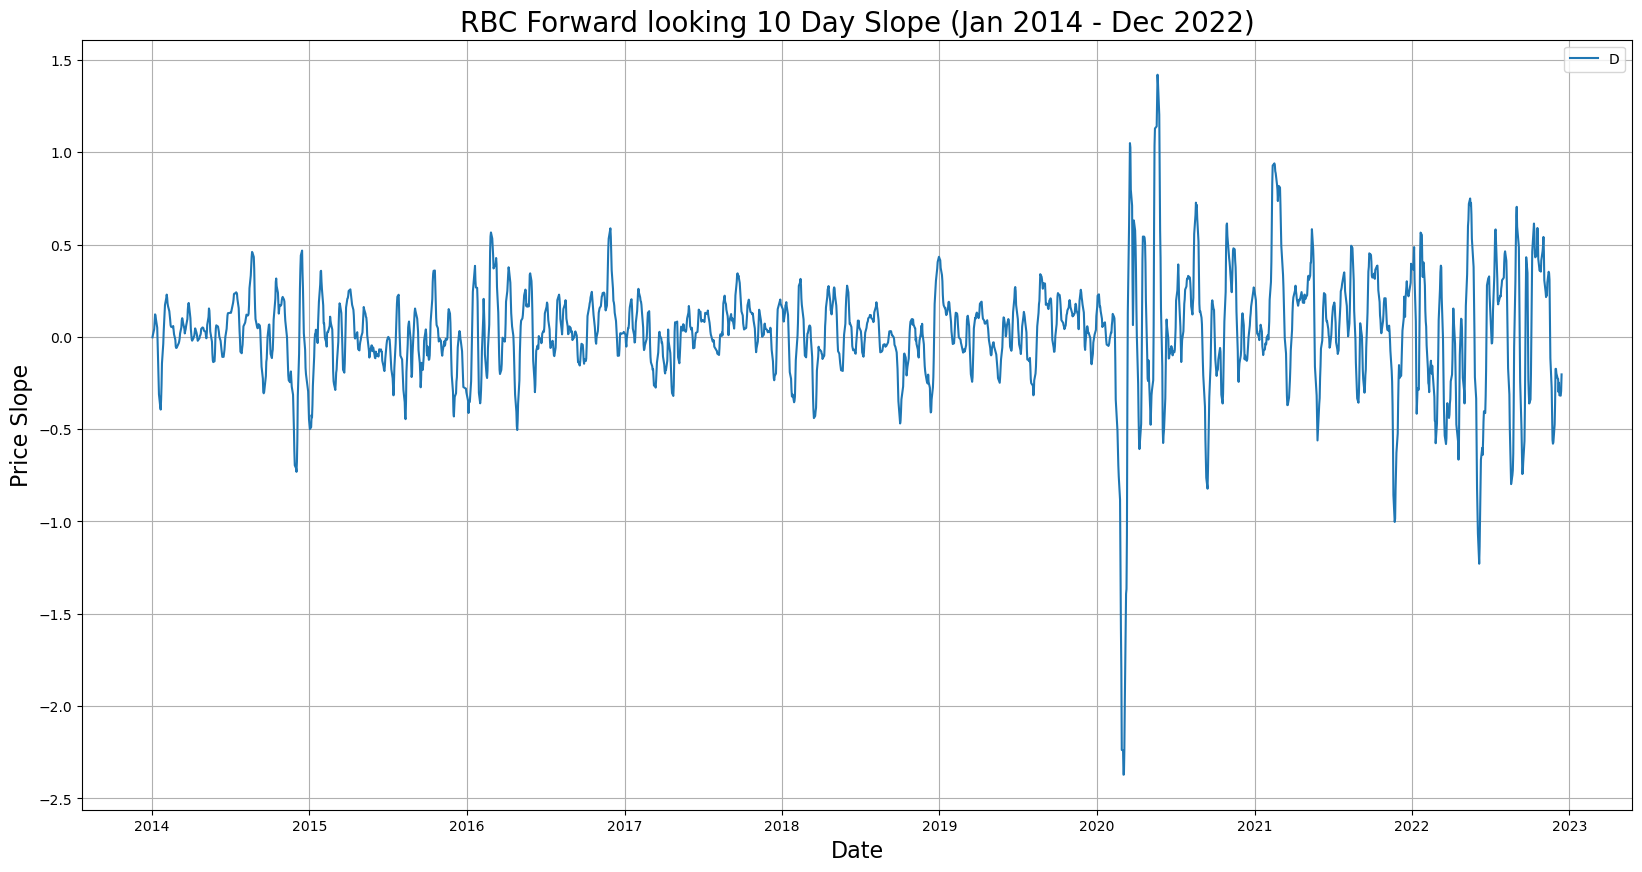

In [11]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

#plt.plot(df_all_stocks_model[['RY.TO']])
plt.plot(df[['high_slope']])
#plt.title("Bank of Montreal (BMO) Daily Close (Jan 2014 - Sep 2022)", fontsize = 20)
plt.title("RBC Forward looking 10 Day Slope (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price Slope", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend('Daily High')
#plt.legend(df_RYx.columns)
plt.grid()

plt.show()


In [12]:
df.to_csv('../Data/Feature_Engineering_NA.csv', encoding='utf-8')